In [1]:
!pip install GPUtil

  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7410 sha256=96ca473c72395a1e5ffb9b560d50524489e3c2af731ca6e96162158af944f6e7
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil


In [2]:

import GPUtil
from tabulate import tabulate  

def Graphics_info():
    gpus=  GPUtil.getGPUs()
    list_gpus=[]
    for gpu in gpus:
        gpu_id = gpu.id
        gpu_name = gpu.name
        gpu_load = f"{gpu.load*100}%"
        gpu_free_memory = f"{gpu.memoryFree}MB"
        gpu_used_memory = f"{gpu.memoryUsed}MB"
        gpu_total_memory = f"{gpu.memoryTotal}MB"
        gpu_temperature = f"{gpu.temperature}`C"
        gpu_uuid = gpu.uuid
        list_gpus.append((gpu_id,gpu_name,gpu_load,gpu_free_memory,gpu_used_memory,gpu_total_memory,
                          gpu_temperature,gpu_uuid))
        
        return(str(tabulate(list_gpus,headers = ("ID","Name","Load","Free Memory","Used Memory",
                                                 "Total Memory","Temperature","UUID"),tablefmt="pretty")))
    
if __name__ == "__main__":
    print(Graphics_info())

+----+----------------------+------+-------------+-------------+--------------+-------------+------------------------------------------+
| ID |         Name         | Load | Free Memory | Used Memory | Total Memory | Temperature |                   UUID                   |
+----+----------------------+------+-------------+-------------+--------------+-------------+------------------------------------------+
| 0  | Tesla P100-PCIE-16GB | 0.0% |  16280.0MB  |    0.0MB    |  16280.0MB   |   39.0`C    | GPU-1b3977f8-f9bc-9143-5b78-aad3b6436b0a |
+----+----------------------+------+-------------+-------------+--------------+-------------+------------------------------------------+


In [3]:
import numpy as np
from keras.utils import Sequence, to_categorical
from PIL import Image


class DataGenerator(Sequence):
    'Generates data for Keras'

    def __init__(self, list_IDs, labels, train_dir='data/train/', batch_size=32, dim=(96, 96), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dir = train_dir
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.shape = (batch_size, *dim, n_channels)
        self.on_epoch_end()
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle is True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' 
        # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty(self.shape)
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i, ] = np.array(Image.open(self.dir + ID + '.tif'))
            # Store class
            y[i] = self.labels[ID]

        # Standardize images
        x_batch = X.astype('float32') / 255
        y_batch = to_categorical(y, num_classes=self.n_classes)
        return [x_batch, y_batch], [y_batch, x_batch]

In [4]:
from keras.backend import *
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops


#own_batch_dot = batch_dot  # force standard implementation 

# import of batch_dot operation from TF 1.13
# https://github.com/tensorflow/tensorflow/blob/v1.13.1/tensorflow/python/keras/backend.py

def own_batch_dot(x, y, axes=None):
  """Batchwise dot product.
  `batch_dot` is used to compute dot product of `x` and `y` when
  `x` and `y` are data in batch, i.e. in a shape of
  `(batch_size, :)`.
  `batch_dot` results in a tensor or variable with less dimensions
  than the input. If the number of dimensions is reduced to 1,
  we use `expand_dims` to make sure that ndim is at least 2.
  Arguments:
      x: Keras tensor or variable with `ndim >= 2`.
      y: Keras tensor or variable with `ndim >= 2`.
      axes: list of (or single) int with target dimensions.
          The lengths of `axes[0]` and `axes[1]` should be the same.
  Returns:
      A tensor with shape equal to the concatenation of `x`'s shape
      (less the dimension that was summed over) and `y`'s shape
      (less the batch dimension and the dimension that was summed over).
      If the final rank is 1, we reshape it to `(batch_size, 1)`.
  Examples:
      Assume `x = [[1, 2], [3, 4]]` and `y = [[5, 6], [7, 8]]`
      `batch_dot(x, y, axes=1) = [[17, 53]]` which is the main diagonal
      of `x.dot(y.T)`, although we never have to calculate the off-diagonal
      elements.
      Shape inference:
      Let `x`'s shape be `(100, 20)` and `y`'s shape be `(100, 30, 20)`.
      If `axes` is (1, 2), to find the output shape of resultant tensor,
          loop through each dimension in `x`'s shape and `y`'s shape:
      * `x.shape[0]` : 100 : append to output shape
      * `x.shape[1]` : 20 : do not append to output shape,
          dimension 1 of `x` has been summed over. (`dot_axes[0]` = 1)
      * `y.shape[0]` : 100 : do not append to output shape,
          always ignore first dimension of `y`
      * `y.shape[1]` : 30 : append to output shape
      * `y.shape[2]` : 20 : do not append to output shape,
          dimension 2 of `y` has been summed over. (`dot_axes[1]` = 2)
      `output_shape` = `(100, 30)`
  ```python
      >>> x_batch = K.ones(shape=(32, 20, 1))
      >>> y_batch = K.ones(shape=(32, 30, 20))
      >>> xy_batch_dot = K.batch_dot(x_batch, y_batch, axes=[1, 2])
      >>> K.int_shape(xy_batch_dot)
      (32, 1, 30)
  ```
  """
  if isinstance(axes, int):
    axes = (axes, axes)
  x_ndim = ndim(x)
  y_ndim = ndim(y)
  if axes is None:
    # behaves like tf.batch_matmul as default
    axes = [x_ndim - 1, y_ndim - 2]
  if x_ndim > y_ndim:
    diff = x_ndim - y_ndim
    y = array_ops.reshape(y,
                          array_ops.concat(
                              [array_ops.shape(y), [1] * (diff)], axis=0))
  elif y_ndim > x_ndim:
    diff = y_ndim - x_ndim
    x = array_ops.reshape(x,
                          array_ops.concat(
                              [array_ops.shape(x), [1] * (diff)], axis=0))
  else:
    diff = 0
  if ndim(x) == 2 and ndim(y) == 2:
    if axes[0] == axes[1]:
      out = math_ops.reduce_sum(math_ops.multiply(x, y), axes[0])
    else:
      out = math_ops.reduce_sum(
          math_ops.multiply(array_ops.transpose(x, [1, 0]), y), axes[1])
  else:
    adj_x = None if axes[0] == ndim(x) - 1 else True
    adj_y = True if axes[1] == ndim(y) - 1 else None
    out = math_ops.matmul(x, y, adjoint_a=adj_x, adjoint_b=adj_y)
  if diff:
    if x_ndim > y_ndim:
      idx = x_ndim + y_ndim - 3
    else:
      idx = x_ndim - 1
    out = array_ops.squeeze(out, list(range(idx, idx + diff)))
  if ndim(out) == 1:
    out = expand_dims(out, 1)
  return out 

In [5]:
import keras.backend as K
import tensorflow as tf
from keras import initializers, layers


class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1) + K.epsilon())

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config


class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, num_capsule, dim_vector] either by the capsule with max length or by an additional 
    input mask. Except the max-length capsule (or specified capsule), all vectors are masked to zeros. Then flatten the
    masked Tensor.
    For example:
        ```
        x = keras.layers.Input(shape=[8, 3, 2])  # batch_size=8, each sample contains 3 capsules with dim_vector=2
        y = keras.layers.Input(shape=[8, 3])  # True labels. 8 samples, 3 classes, one-hot coding.
        out = Mask()(x)  # out.shape=[8, 6]
        # or
        out2 = Mask()([x, y])  # out2.shape=[8,6]. Masked with true labels y. Of course y can also be manipulated.
        ```
    """
    def call(self, inputs, **kwargs):
        if type(inputs) is list:  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
            # compute lengths of capsules
            x = K.sqrt(K.sum(K.square(inputs), -1))
            # generate the mask which is a one-hot code.
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = K.one_hot(indices=K.argmax(x, 1), num_classes=x.get_shape().as_list()[1])

        # inputs.shape=[None, num_capsule, dim_capsule]
        # mask.shape=[None, num_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        masked = K.batch_flatten(inputs * K.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        config = super(Mask, self).get_config()
        return config


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (1. + s_squared_norm)
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule]
        inputs_expand = K.expand_dims(inputs, 1)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule]
        inputs_tiled = K.tile(inputs_expand, [1, self.num_capsule, 1, 1])

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule]
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # Regard the first two dimensions as `batch` dimension,
        # then matmul: [input_dim_capsule] x [dim_capsule, input_dim_capsule]^T -> [dim_capsule].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = K.map_fn(lambda x: own_batch_dot(x, self.W, [2, 3]), elems=inputs_tiled)

        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, self.input_num_capsule].
        b = tf.zeros(shape=[K.shape(inputs_hat)[0], self.num_capsule, self.input_num_capsule])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # c.shape=[batch_size, num_capsule, input_num_capsule]
            c = tf.nn.softmax(b, axis=1)

            # c.shape =  [batch_size, num_capsule, input_num_capsule]
            # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
            # The first two dimensions as `batch` dimension,
            # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule].
            # outputs.shape=[None, num_capsule, dim_capsule]
            outputs = squash(own_batch_dot(c, inputs_hat, [2, 2]))  # [None, 10, 16]

            if i < self.routings - 1:
                # outputs.shape =  [None, num_capsule, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension,
                # then matmal: [dim_capsule] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
                # b.shape=[batch_size, num_capsule, input_num_capsule]
                b += own_batch_dot(outputs, inputs_hat, [2, 3])
        # End: Routing algorithm -----------------------------------------------------------------------#

        return outputs

    def compute_output_shape(self, input_shape):
        return None, self.num_capsule, self.dim_capsule

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_capsule: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    output = layers.Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)

In [6]:
import numpy as np
import pandas as pd
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#from utils import plot_log
from PIL import Image
#from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask
#from generator import DataGenerator

K.set_image_data_format('channels_last')


def CapsNet(input_shape, n_class, routings):
    
    x = layers.Input(shape=input_shape)

    # Layers 1: Just some conventional Conv2D layers
    conv1 = layers.Conv2D(filters=64, kernel_size=4, strides=2, activation='relu', name='Conv1')(x)
    #conv2 = layers.Conv2D(filters=128, kernel_size=4, strides=2, activation='relu', name='conv2')(conv1)
    #conv3 = layers.Conv2D(filters=256, kernel_size=6, strides=2, activation='relu', name='conv3')(conv2)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=6, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    classcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='classcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(classcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([classcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(classcaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    return train_model, eval_model


def margin_loss(y_true, y_pred):
    
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.sum(L, axis=-1)


def train(model, train_gen, val_gen, args):
    
    # callbacks
    log = callbacks.CSVLogger(args.save_dir + '/log.csv')
    tb = callbacks.TensorBoard(log_dir=args.save_dir + '/tensorboard-logs',
                               batch_size=args.batch_size, histogram_freq=int(args.debug))
    checkpoint = callbacks.ModelCheckpoint(args.save_dir + '/weights-{epoch:02d}.h5', monitor='val_capsnet_acc',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: args.lr * (args.lr_decay ** epoch))

    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=args.lr),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., args.lam_recon],
                  metrics={'capsnet': 'accuracy'})

    model.fit_generator(generator=train_gen,
                        epochs=args.epochs,
                        validation_data=val_gen,
                        callbacks=[log, tb, checkpoint, lr_decay],
                        use_multiprocessing=True,
                        workers=6,
                        verbose=1)

    model.save_weights(args.save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % args.save_dir)

    #from utils import plot_log
    plot_log(args.save_dir + '/log.csv', show=True)

    return model


def load_generators(data_dir):
    # Parameters
    params = {'dim': (96,96),
              'batch_size': 100,
              'n_classes': 2,
              'n_channels': 3,
              'shuffle': True}
    
    # Data
    data = pd.read_csv(data_dir + 'train_labels.csv')
    train, val = train_test_split(data, test_size = 0.1, random_state=42)
    partition = {"train":list(train['id']), "validation":list(val['id'])}
    labels = dict(zip(data['id'], data['label']))

    train_dir = data_dir + "train/"

    # Generators
    train_gen = DataGenerator(partition['train'], labels, train_dir, **params)
    val_gen = DataGenerator(partition['validation'], labels, train_dir, **params)
    
    return train_gen, val_gen


if __name__ == "__main__":
    import os
    import argparse
    from keras import callbacks

    # setting the hyper parameters
    parser = argparse.ArgumentParser(description="Capsule Network on Histopathologic Cancer Detection Dataset.")
    parser.add_argument('--epochs', default=15, type=int)
    parser.add_argument('--batch_size', default=100, type=int)
    parser.add_argument('--lr', default=0.001, type=float,
                        help="Initial learning rate")
    parser.add_argument('--lr_decay', default=0.9, type=float,
                        help="The value multiplied by lr at each epoch. Set a larger value for larger epochs")
    parser.add_argument('--lam_recon', default=0.392, type=float,
                        help="The coefficient for the loss of decoder")
    parser.add_argument('-r', '--routings', default=3, type=int,
                        help="Number of iterations used in routing algorithm. should > 0")
    parser.add_argument('--debug', action='store_true',
                        help="Save weights by TensorBoard")
    parser.add_argument('--save_dir', default='results')
    parser.add_argument('--data_dir', default='../input/histopathologic-cancer-detection/')
    parser.add_argument('-w', '--weights', default=None,
                        help="The path of the saved weights. Should be specified when testing")
    args = parser.parse_args([])
    print(args)

    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)

    train_gen, val_gen = load_generators(args.data_dir)

    # define model
    model, eval_model = CapsNet(input_shape=train_gen.shape[1:],
                                n_class=train_gen.n_classes,
                                routings=args.routings)
    model.summary()

    # train or test
    if args.weights is not None:  # init the model weights with provided one
        model.load_weights(args.weights)
    train(model=model, train_gen=train_gen, val_gen=val_gen, args=args)


Namespace(batch_size=100, data_dir='../input/histopathologic-cancer-detection/', debug=False, epochs=15, lam_recon=0.392, lr=0.001, lr_decay=0.9, routings=3, save_dir='results', weights=None)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 47, 47, 64)   3136        input_1[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 21, 21, 256)  590080      Conv1[0][0]                      
__________________________________________________________________________________________________
p

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
1980/1980 [==============================] - 759s 380ms/step - loss: 0.1788 - capsnet_loss: 0.1592 - decoder_loss: 0.0500 - capsnet_accuracy: 0.7552 - val_loss: 0.1410 - val_capsnet_loss: 0.1241 - val_decoder_loss: 0.0432 - val_capsnet_accuracy: 0.8016
Epoch 2/15
1980/1980 [==============================] - 720s 362ms/step - loss: 0.1387 - capsnet_loss: 0.1230 - decoder_loss: 0.0400 - capsnet_accuracy: 0.8063 - val_loss: 0.1352 - val_capsnet_loss: 0.1203 - val_decoder_loss: 0.0381 - val_capsnet_accuracy: 0.8106
Epoch 3/15
1980/1980 [==============================] - 721s 363ms/step - loss: 0.1282 - capsnet_loss: 0.1132 - decoder_loss: 0.0382 - capsnet_accuracy: 0.8218 - val_loss: 0.1311 - val_capsnet_loss: 0.1164 - val_decoder_loss: 0.0373 - val_capsnet_accuracy: 0.8200
Epoch 4/15
1980/1980 [==============================] - 723s 365ms/step - loss: 0.1187 - capsnet_loss: 0.1041 - decoder_loss: 0.0373 - capsnet_accuracy: 0.8356 - val_loss: 0.1173 - val_capsnet_loss: 0.1030 - 

NameError: name 'plot_log' is not defined

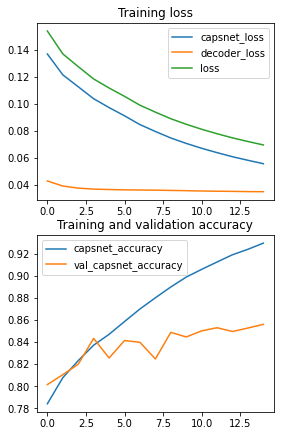

In [7]:
import numpy as np
from matplotlib import pyplot as plt
import csv
import math
import pandas

def plot_log(filename, show=True):

    data = pandas.read_csv(filename)

    fig = plt.figure(figsize=(4,6))
    fig.subplots_adjust(top=0.95, bottom=0.05, right=0.95)
    fig.add_subplot(211)
    for key in data.keys():
        if key.find('loss') >= 0 and not key.find('val') >= 0:  # training loss
            plt.plot(data['epoch'].values, data[key].values, label=key)
    plt.legend()
    plt.title('Training loss')

    fig.add_subplot(212)
    for key in data.keys():
        if key.find('acc') >= 0:  # acc
            plt.plot(data['epoch'].values, data[key].values, label=key)
    plt.legend()
    plt.title('Training and validation accuracy')

    # fig.savefig('result/log.png')
    if show:
        plt.show()


if __name__=="__main__":
    plot_log('results/log.csv')